# Random Forest Model

In [1]:
import numpy as np
import pandas as pd

In [2]:
train = pd.read_csv('data/train.csv')
predict = pd.read_csv('data/test.csv')

In [3]:
passenger_id = predict[['id']].copy()

In [4]:
train.head()

,id,Podcast_Name,Episode_Title,Episode_Length_minutes,Genre,Host_Popularity_percentage,Publication_Day,Publication_Time,Guest_Popularity_percentage,Number_of_Ads,Episode_Sentiment,Listening_Time_minutes
0,0,Mystery Matters,Episode 98,NaN,True Crime,74.81,Thursday,Night,NaN,0.0,Positive,31.41998
1,1,Joke Junction,Episode 26,119.80,Comedy,66.95,Saturday,Afternoon,75.95,2.0,Negative,88.01241
2,2,Study Sessions,Episode 16,73.90,Education,69.97,Tuesday,Evening,8.97,0.0,Negative,44.92531
3,3,Digital Digest,Episode 45,67.17,Technology,57.22,Monday,Morning,78.70,2.0,Positive,46.27824
4,4,Mind & Body,Episode 86,110.51,Health,80.07,Monday,Afternoon,58.68,3.0,Neutral,75.61031


In [5]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
id,750000.0,374999.500000,216506.495284,0.0,187499.75000,374999.50000,562499.25000,749999.00
Episode_Length_minutes,662907.0,64.504738,32.969603,0.0,35.73000,63.84000,94.07000,325.24
Host_Popularity_percentage,750000.0,59.859901,22.873098,1.3,39.41000,60.05000,79.53000,119.46
Guest_Popularity_percentage,603970.0,52.236449,28.451241,0.0,28.38000,53.58000,76.60000,119.91
Number_of_Ads,749999.0,1.348855,1.151130,0.0,0.00000,1.00000,2.00000,103.91
Listening_Time_minutes,750000.0,45.437406,27.138306,0.0,23.17835,43.37946,64.81158,119.97


In [6]:
predict.isnull().sum()

id                                 0
Podcast_Name                       0
Episode_Title                      0
Episode_Length_minutes         28736
Genre                              0
Host_Popularity_percentage         0
Publication_Day                    0
Publication_Time                   0
Guest_Popularity_percentage    48832
Number_of_Ads                      0
Episode_Sentiment                  0
dtype: int64

In [7]:
train.isnull().sum()

id                                  0
Podcast_Name                        0
Episode_Title                       0
Episode_Length_minutes          87093
Genre                               0
Host_Popularity_percentage          0
Publication_Day                     0
Publication_Time                    0
Guest_Popularity_percentage    146030
Number_of_Ads                       1
Episode_Sentiment                   0
Listening_Time_minutes              0
dtype: int64

In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 750000 entries, 0 to 749999
Data columns (total 12 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   id                           750000 non-null  int64  
 1   Podcast_Name                 750000 non-null  object 
 2   Episode_Title                750000 non-null  object 
 3   Episode_Length_minutes       662907 non-null  float64
 4   Genre                        750000 non-null  object 
 5   Host_Popularity_percentage   750000 non-null  float64
 6   Publication_Day              750000 non-null  object 
 7   Publication_Time             750000 non-null  object 
 8   Guest_Popularity_percentage  603970 non-null  float64
 9   Number_of_Ads                749999 non-null  float64
 10  Episode_Sentiment            750000 non-null  object 
 11  Listening_Time_minutes       750000 non-null  float64
dtypes: float64(5), int64(1), object(6)
memory usage: 68.7+ MB


In [9]:
train.nunique()

id                             750000
Podcast_Name                       48
Episode_Title                     100
Episode_Length_minutes          12268
Genre                              10
Host_Popularity_percentage       8038
Publication_Day                     7
Publication_Time                    4
Guest_Popularity_percentage     10019
Number_of_Ads                      12
Episode_Sentiment                   3
Listening_Time_minutes          42807
dtype: int64

In [10]:
train.head()

,id,Podcast_Name,Episode_Title,Episode_Length_minutes,Genre,Host_Popularity_percentage,Publication_Day,Publication_Time,Guest_Popularity_percentage,Number_of_Ads,Episode_Sentiment,Listening_Time_minutes
0,0,Mystery Matters,Episode 98,NaN,True Crime,74.81,Thursday,Night,NaN,0.0,Positive,31.41998
1,1,Joke Junction,Episode 26,119.80,Comedy,66.95,Saturday,Afternoon,75.95,2.0,Negative,88.01241
2,2,Study Sessions,Episode 16,73.90,Education,69.97,Tuesday,Evening,8.97,0.0,Negative,44.92531
3,3,Digital Digest,Episode 45,67.17,Technology,57.22,Monday,Morning,78.70,2.0,Positive,46.27824
4,4,Mind & Body,Episode 86,110.51,Health,80.07,Monday,Afternoon,58.68,3.0,Neutral,75.61031


# Preprocessing of data

In [11]:
def create_features(df):
    df[['Episode_Name','Episode_Num']] = df['Episode_Title'].str.split(' ', expand=True)
    df['Episode_Num'] = df['Episode_Num'].astype(int)

    # ジャンルごとにホストの人気度の平均を計算して，それを辞書型に変換
    #genre_to_weight = df.groupby('Genre')['Host_Popularity_percentage'].mean().to_dict()
    #df['Host_Popularity_by_Genre'] =  df['Host_Popularity_percentage'] * df['Genre'].map(genre_to_weight)
    """
    # 広告数とホスト人気の関係    
    ads_to_weight = df.groupby('Number_of_Ads')['Host_Popularity_percentage'].mean().to_dict()
    df['Host_Popularity_by_Ads'] =  df['Host_Popularity_percentage'] * df['Number_of_Ads'].map(ads_to_weight)
    
    # 視聴時間の長さ / 広告数
    ads_to_weight = df.groupby('Number_of_Ads')['Episode_Length_minutes'].mean().to_dict()
    df['Episode_Ads'] =  df['Episode_Length_minutes'] / df['Number_of_Ads'].map(ads_to_weight)

    
    """
    # ホストの人気 ＊ エピソードの長さ
    #df['Host_Popularity_by_Episode_Length'] = df['Host_Popularity_percentage'] * df['Episode_Length_minutes']

    # ホスト人気 * ゲスト人気
    #df['Host_Guest_Popularity'] = df['Host_Popularity_percentage'] * df['Guest_Popularity_percentage']
    
    return df

train = create_features(train)
predict = create_features(predict)

In [12]:
train.nunique()

id                             750000
Podcast_Name                       48
Episode_Title                     100
Episode_Length_minutes          12268
Genre                              10
Host_Popularity_percentage       8038
Publication_Day                     7
Publication_Time                    4
Guest_Popularity_percentage     10019
Number_of_Ads                      12
Episode_Sentiment                   3
Listening_Time_minutes          42807
Episode_Name                        1
Episode_Num                       100
dtype: int64

In [13]:
# columns to drop 
def delete_columns(df):
    #df.drop(columns=['id','Episode_Title','Episode_Length_minutes','Guest_Popularity_percentage'], inplace=True)
    df.drop(columns=['id','Episode_Title','Episode_Name'], inplace=True)
    #df.drop(columns=['Episode_Length_minutes','Guest_Popularity_percentage'], inplace=True)

    return df

train = delete_columns(train)
predict = delete_columns(predict)

In [14]:
train['Number_of_Ads'] = train['Number_of_Ads'].fillna(train['Number_of_Ads'].mean())

def convert_fillna(df):
    df['Episode_Length_minutes'] = df['Episode_Length_minutes'].fillna(-999999999999)
    df['Guest_Popularity_percentage'] = df['Guest_Popularity_percentage'].fillna(-999999999999)


In [15]:
train.head()

,Podcast_Name,Episode_Length_minutes,Genre,Host_Popularity_percentage,Publication_Day,Publication_Time,Guest_Popularity_percentage,Number_of_Ads,Episode_Sentiment,Listening_Time_minutes,Episode_Num
0,Mystery Matters,NaN,True Crime,74.81,Thursday,Night,NaN,0.0,Positive,31.41998,98
1,Joke Junction,119.80,Comedy,66.95,Saturday,Afternoon,75.95,2.0,Negative,88.01241,26
2,Study Sessions,73.90,Education,69.97,Tuesday,Evening,8.97,0.0,Negative,44.92531,16
3,Digital Digest,67.17,Technology,57.22,Monday,Morning,78.70,2.0,Positive,46.27824,45
4,Mind & Body,110.51,Health,80.07,Monday,Afternoon,58.68,3.0,Neutral,75.61031,86


# Data preparation before modeling

### Since there are few tpyes of object data,label encoding will be applied


In [16]:
# Label Encoding
from sklearn.preprocessing import LabelEncoder

def label_enocding(df,columns):
    le = LabelEncoder()

    for col in columns:
        df[col] = le.fit_transform(df[col])
    return df

encoding_cols = ['Podcast_Name','Genre','Publication_Day',
                 'Publication_Time','Episode_Sentiment']

train = label_enocding(train, encoding_cols)
predict = label_enocding(predict, encoding_cols)


In [17]:
train.head()

,Podcast_Name,Episode_Length_minutes,Genre,Host_Popularity_percentage,Publication_Day,Publication_Time,Guest_Popularity_percentage,Number_of_Ads,Episode_Sentiment,Listening_Time_minutes,Episode_Num
0,34,NaN,9,74.81,4,3,NaN,0.0,2,31.41998,98
1,24,119.80,1,66.95,2,0,75.95,2.0,0,88.01241,26
2,40,73.90,2,69.97,5,1,8.97,0.0,0,44.92531,16
3,10,67.17,8,57.22,1,2,78.70,2.0,2,46.27824,45
4,31,110.51,3,80.07,1,0,58.68,3.0,1,75.61031,86


In [18]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 750000 entries, 0 to 749999
Data columns (total 11 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   Podcast_Name                 750000 non-null  int64  
 1   Episode_Length_minutes       662907 non-null  float64
 2   Genre                        750000 non-null  int64  
 3   Host_Popularity_percentage   750000 non-null  float64
 4   Publication_Day              750000 non-null  int64  
 5   Publication_Time             750000 non-null  int64  
 6   Guest_Popularity_percentage  603970 non-null  float64
 7   Number_of_Ads                750000 non-null  float64
 8   Episode_Sentiment            750000 non-null  int64  
 9   Listening_Time_minutes       750000 non-null  float64
 10  Episode_Num                  750000 non-null  int64  
dtypes: float64(5), int64(6)
memory usage: 62.9 MB


In [19]:
from sklearn.model_selection import train_test_split

def split_data(df, test_size=0.2, random_state=42):
    X = df.drop(columns=['Listening_Time_minutes'])
    y = df['Listening_Time_minutes']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = split_data(train)
predict_X = predict.copy()

# Model Construction

In [20]:
from sklearn.ensemble import RandomForestRegressor

# ランダムフォレストモデルの構築
def build_random_forest_model(n_estimators=100, max_depth=5):
    """ランダムフォレスト回帰モデルを構築する関数"""
    model = RandomForestRegressor(
        # 決定木の数
        n_estimators=n_estimators,
        # 決定木の最大深さ
        max_depth=max_depth,
        # 乱数シード
        random_state=42,
        # 並列処理（CPUコアすべて使うなら -1）
        n_jobs=-1
    )
    return model

# モデルの構築
rf_model = build_random_forest_model()

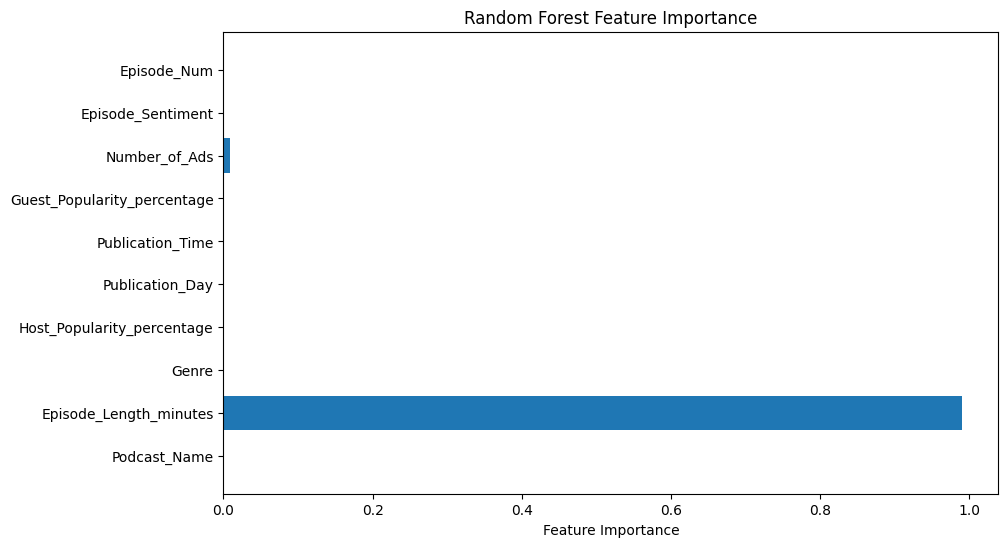

In [21]:
import matplotlib.pyplot as plt

# Train XGBoost model
rf_model.fit(X_train, y_train) # XGBoostモデルの学習

# Feature importance
feature_importances = rf_model.feature_importances_  # 特徴量の重要度を取得
features = X_train.columns  # 特徴量の名前を取得（X_trainがDataFrameの場合）

# プロット
plt.figure(figsize=(10, 6))
plt.barh(features, feature_importances)  # 水平バーグラフ
plt.xlabel('Feature Importance')  # X軸ラベル
plt.title('Random Forest Feature Importance')  # タイトル
plt.show()  # グラフの表示

# Model evalution

In [22]:
rf_pred = rf_model.predict(X_test)

In [23]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
def evaluate_metrics(y_true,y_pred):
    
    results = []

    def calulate_metrics(y_true, y_pred):
        mse = mean_squared_error(y_true, y_pred)
        mae = mean_absolute_error(y_true, y_pred)
        r2 = r2_score(y_true, y_pred)

        return {
            'MSE': mse,
            'RMSE': mae,
            'R2': r2
        }
    results.append(calulate_metrics(y_true, y_pred))

    return pd.DataFrame(results)

results = evaluate_metrics(y_test, rf_pred)
display(results)

,MSE,RMSE,R2
0,176.951949,9.72745,0.75952


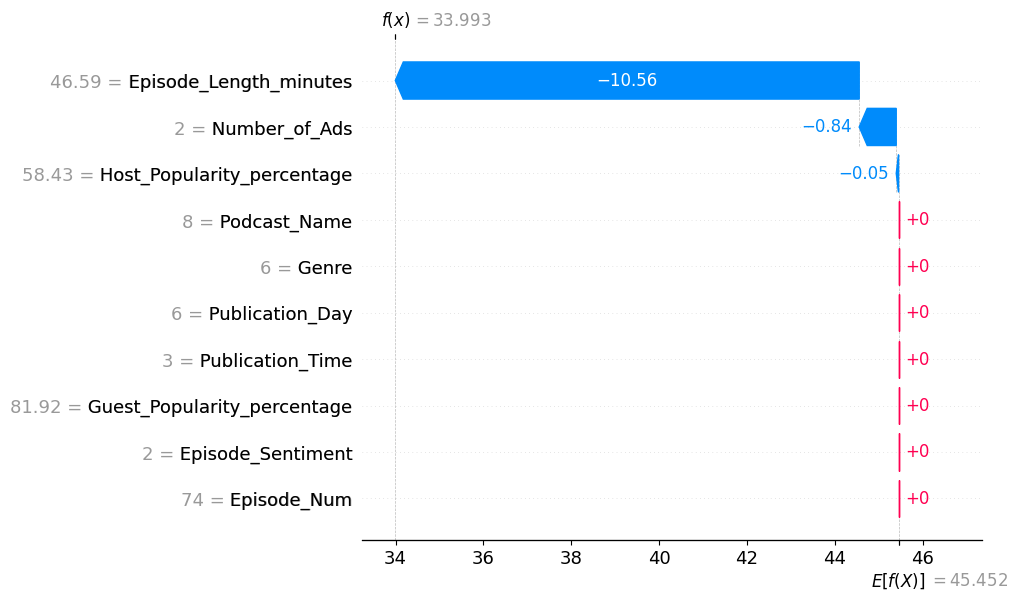

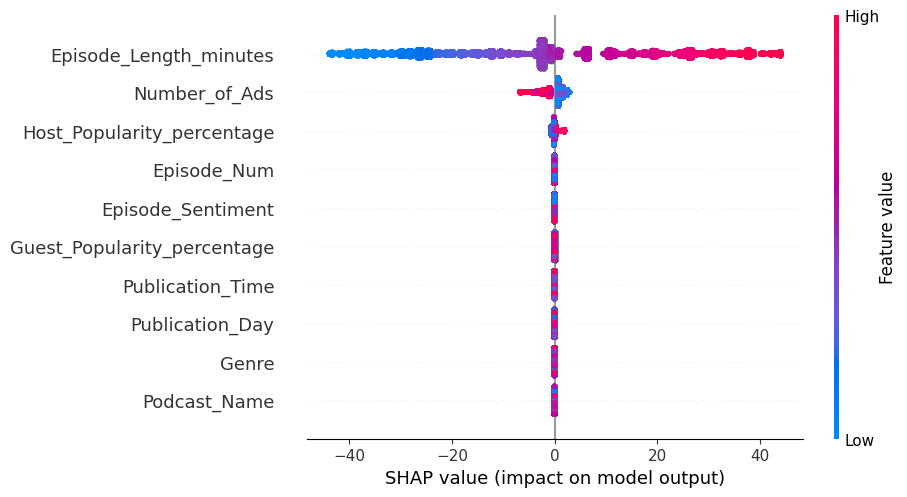

In [24]:
import shap

def explain_model(model):
    # SHAP explainerを作成（TreeExplainerはXGBoostなどに最適）
    explainer = shap.Explainer(model)

    # SHAP値を計算（X_testに対して）
    shap_values = explainer(X_test)

    # 可視化（例：1件目の予測理由）
    shap.plots.waterfall(shap_values[0])

    # 全体の特徴量の影響（要約プロット）
    shap.plots.beeswarm(shap_values)

explain_model(rf_model)


# Optuna

In [25]:
import optuna
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

def optimize_random_forest(trial):
    params = {
    'n_estimators': trial.suggest_int('n_estimators', 50, 300),  # 上限を500から300に変更
    'max_depth': trial.suggest_int('max_depth', 3, 15),  # 上限を20から15に変更
    # その他のパラメータはそのままでもOK
    'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
    'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 4),
    'max_features': trial.suggest_float('max_features', 0.1, 1.0),
    'bootstrap': trial.suggest_categorical('bootstrap', [True, False]),
    'random_state': 42,
    'n_jobs': -1  # 並列計算を使って高速化を図る
}

    
    model = RandomForestRegressor(**params)
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    
    return mse

# Create the study and optimize
study = optuna.create_study(direction='minimize')
study.optimize(optimize_random_forest, n_trials=10)

# Display best results
print('Best trial:')
trial = study.best_trial
print(f"  MSE: {trial.value}")
print("  Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

# Use the best parameters to create and train the final model
optimized_rf = RandomForestRegressor(**trial.params, random_state=42, n_jobs=-1)
optimized_rf.fit(X_train, y_train)

# You can now use optimized_rf to predict on new data


[I 2025-04-16 22:16:14,034] A new study created in memory with name: no-name-2e4d39df-fc1f-4ab3-ae4c-662040660b04
[I 2025-04-16 22:16:49,789] Trial 0 finished with value: 169.5296822245026 and parameters: {'n_estimators': 235, 'max_depth': 12, 'min_samples_split': 7, 'min_samples_leaf': 3, 'max_features': 0.6721240450844062, 'bootstrap': True}. Best is trial 0 with value: 169.5296822245026.
[I 2025-04-16 22:16:56,438] Trial 1 finished with value: 313.8046258034607 and parameters: {'n_estimators': 204, 'max_depth': 10, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': 0.1326612439453192, 'bootstrap': True}. Best is trial 0 with value: 169.5296822245026.
[I 2025-04-16 22:17:15,494] Trial 2 finished with value: 169.73267548968352 and parameters: {'n_estimators': 163, 'max_depth': 12, 'min_samples_split': 8, 'min_samples_leaf': 4, 'max_features': 0.541371827118672, 'bootstrap': True}. Best is trial 0 with value: 169.5296822245026.
[I 2025-04-16 22:17:17,867] Trial 3 finished 

Best trial:
  MSE: 168.48114627649736
  Params: 
    n_estimators: 219
    max_depth: 13
    min_samples_split: 4
    min_samples_leaf: 1
    max_features: 0.8266151718954375
    bootstrap: True


RandomForestRegressor(max_depth=13, max_features=0.8266151718954375,
                      min_samples_split=4, n_estimators=219, n_jobs=-1,
                      random_state=42)

In [26]:
optimized_pred = optimized_rf.predict(X_test)
optimized_metrics = evaluate_metrics(y_test,  optimized_pred) # 評価
display(optimized_metrics)

,MSE,RMSE,R2
0,168.481146,9.417268,0.771032


In [27]:
import joblib

# モデルの保存
#joblib.dump(optimized_rf, 'model/random_forest/rf_model.pkl')  # .pkl 拡張子が一般的

# モデルの読み込み
#loaded_model = joblib.load('model/random_forest/rf_model.pkl')


In [28]:
predixt_y = optimized_rf.predict(predict_X)

predict_df = pd.DataFrame(predixt_y , columns=['Listening_Time_minutes'])

submission = pd.concat([passenger_id, predict_df], axis=1)

display(submission.head())

,id,Listening_Time_minutes
0,750000,56.842051
1,750001,18.889063
2,750002,49.864429
3,750003,79.237306
4,750004,46.936710


In [29]:
#submission.to_csv('submit/rf_submit/rf_submit_1.csv', index=False)